In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import re
import plotly.graph_objects as go

In [2]:
train = pd.read_csv('/content/drive/MyDrive/sber_ml_hack/data/train.csv', usecols=['client_id', 'gender'])
mcc_codes = pd.read_csv('/content/drive/MyDrive/sber_ml_hack/data/mcc_codes.csv', sep=';')
test_sample_submission = pd.read_csv('/content/drive/MyDrive/sber_ml_hack/data/test_sample_submission.csv', usecols=['client_id', 'probability'])
test = pd.read_csv('/content/drive/MyDrive/sber_ml_hack/data/test.csv', usecols=['client_id'])
trans_types = pd.read_csv('/content/drive/MyDrive/sber_ml_hack/data/trans_types.csv', sep=';')
transactions = pd.read_csv('/content/drive/MyDrive/sber_ml_hack/data/transactions.csv')

In [3]:
print('Size of datasets:\n')
print('train', train.shape)
print('mcc_codes', mcc_codes.shape)
print('trans_types', trans_types.shape)
print('test', test.shape)
print('transactions', transactions.shape)

Size of datasets:

train (7560, 2)
mcc_codes (184, 2)
trans_types (155, 2)
test (840, 1)
transactions (3563529, 7)


In [4]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg


In [5]:
print('duplicated values of transactions: ', transactions.duplicated().sum())
print('-'*20)
print('null values of transactions: ', transactions.isnull().sum())
print('-'*20)
print('null values of mcc codes: ', mcc_codes.isnull().sum())
print('-'*20)
print('null values of transactions types: ', trans_types.isnull().sum())

duplicated values of transactions:  4
--------------------
null values of transactions:  client_id           0
trans_time          0
mcc_code            0
trans_type          0
amount              0
term_id       1443778
trans_city          0
dtype: int64
--------------------
null values of mcc codes:  mcc_code           0
mcc_description    0
dtype: int64
--------------------
null values of transactions types:  trans_type           0
trans_description    0
dtype: int64


In [6]:
print('Number of unique:')
print(transactions['client_id'].nunique())

# top 10 clients who most often used the services of the bank
transactions['client_id'].value_counts()[:10]

Number of unique:
8400


fbf94bb37e250669ea74b20ddaa89e0e    84313
e91858185ae43cf3970220748893a01b    14404
210a288dba0bd3bf6ce90f1f1b188951    13876
7364b8067c0c257b45efd73c3d0a4028    11699
07e279042b1da23710fa2f65034d30b9    11447
e43f6f0ead88c8a17fc0543aa3e1599a    11442
aba68a1204a662908cebfc09a1d5bbd3    10520
f74c1398ead286f297e003b5e810ee99     9356
8d69e4ecae4b509d528b9a0168f749d0     7998
c20371cb1683ff049f277439b4aafb28     7660
Name: client_id, dtype: int64

In [7]:
def preproc(x):
  if x > 0:
    return np.log(1 + x)
  return -np.log(1 - x)

In [8]:
transactions['amount_log'] = transactions['amount'].apply(preproc)

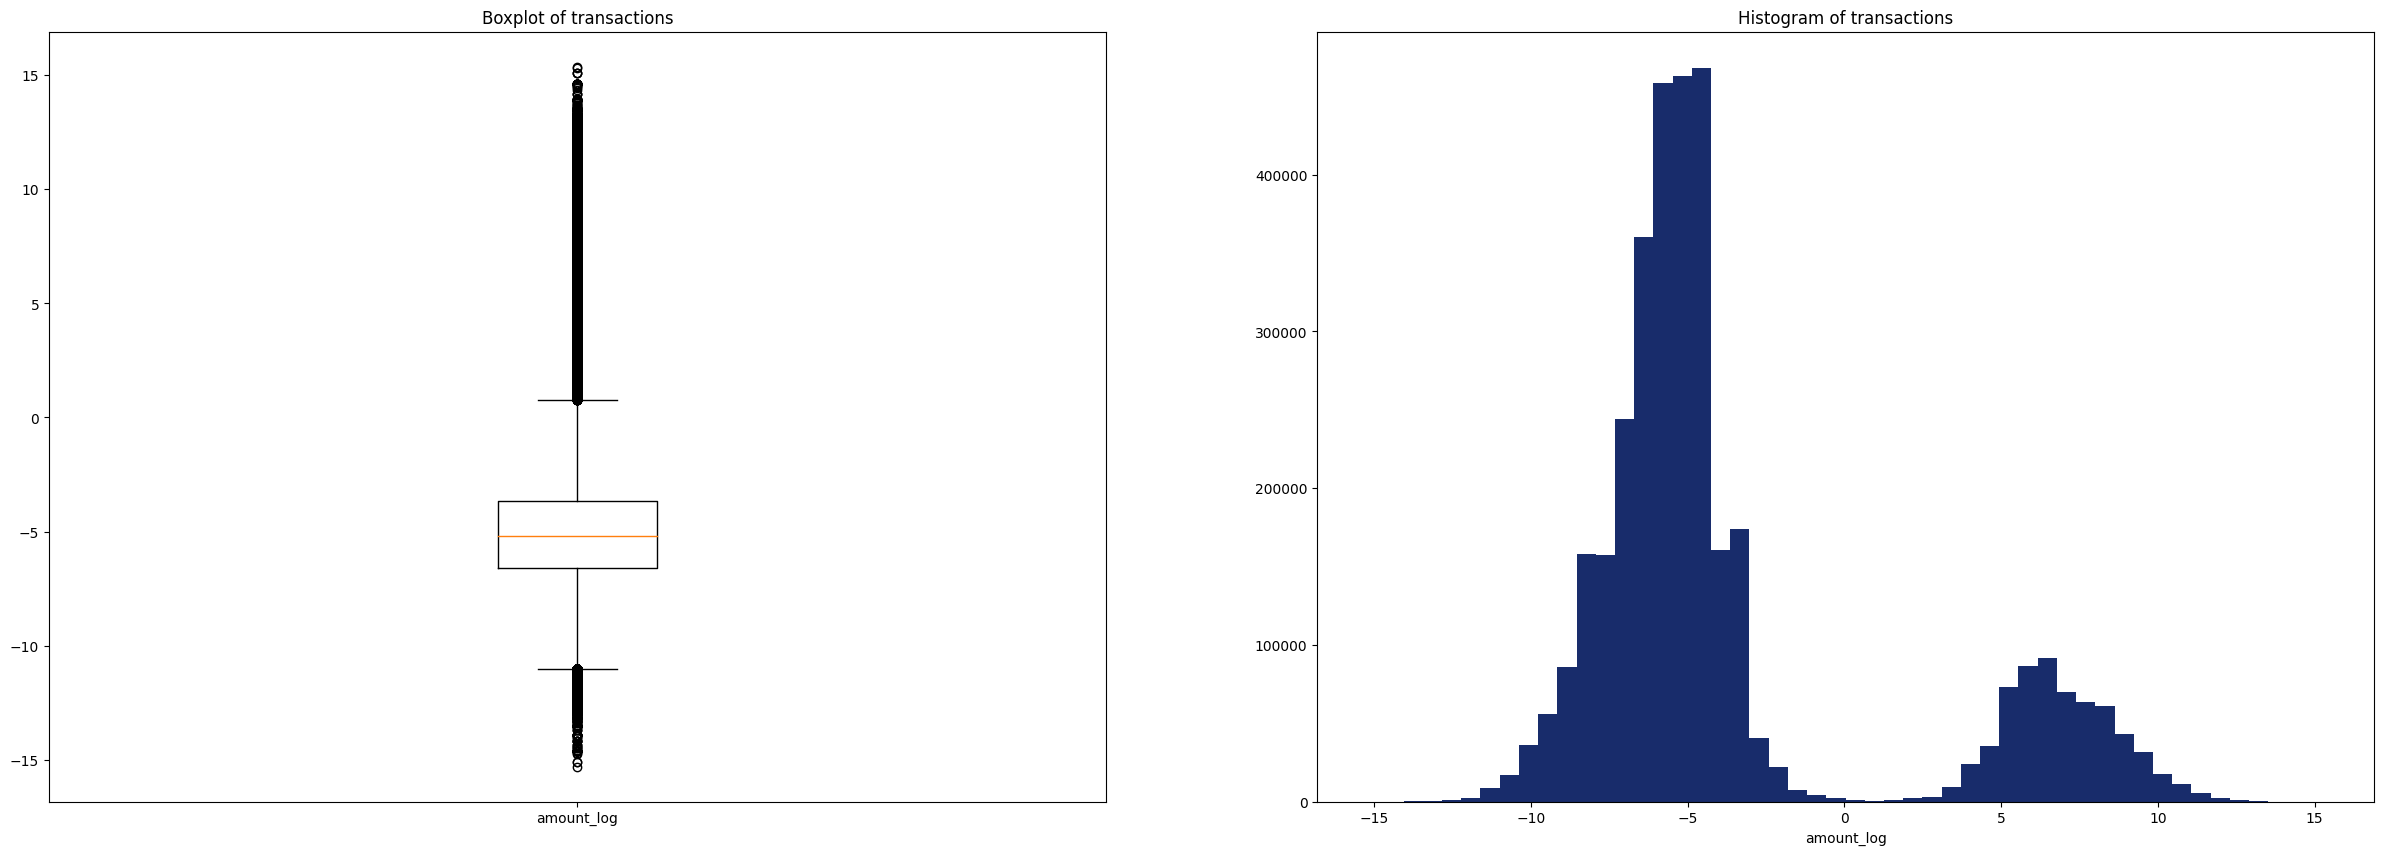

In [9]:

fig, axes = plt.subplots(1, 2, figsize=(30, 10))
axes[0].set_title('Boxplot of transactions')
labels = ['amount_log']
axes[0].boxplot(transactions['amount_log'], labels=labels)

axes[1].set_title('Histogram of transactions')

axes[1].hist(transactions['amount_log'], bins=50, label = 'amount_log', color = '#182c6bff')
axes[1].set_xlabel('amount_log')


plt.show()





In [10]:
def remove_outlier_IQR(df):
    # IQR
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    # removing the outliers
    df_without_outliers=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    # return data without outliers
    return df_without_outliers

data_with_no_outliers=remove_outlier_IQR(transactions['amount_log'])


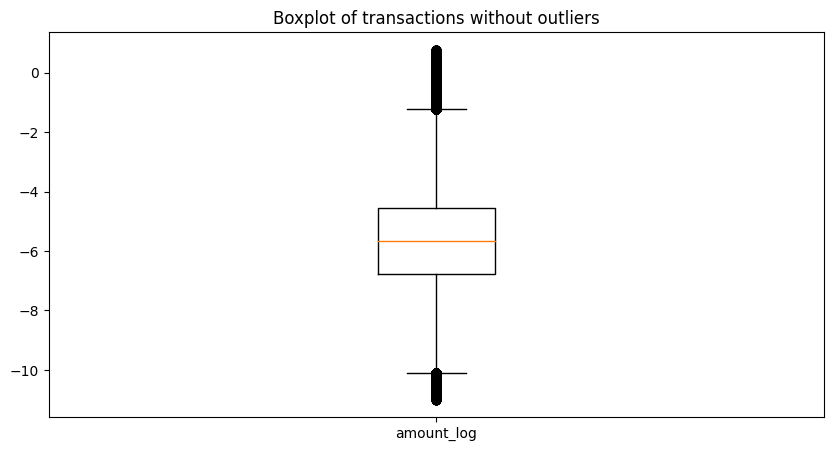

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Boxplot of transactions without outliers')

labels = ['amount_log']
ax.boxplot(data_with_no_outliers, labels=labels)
plt.show()

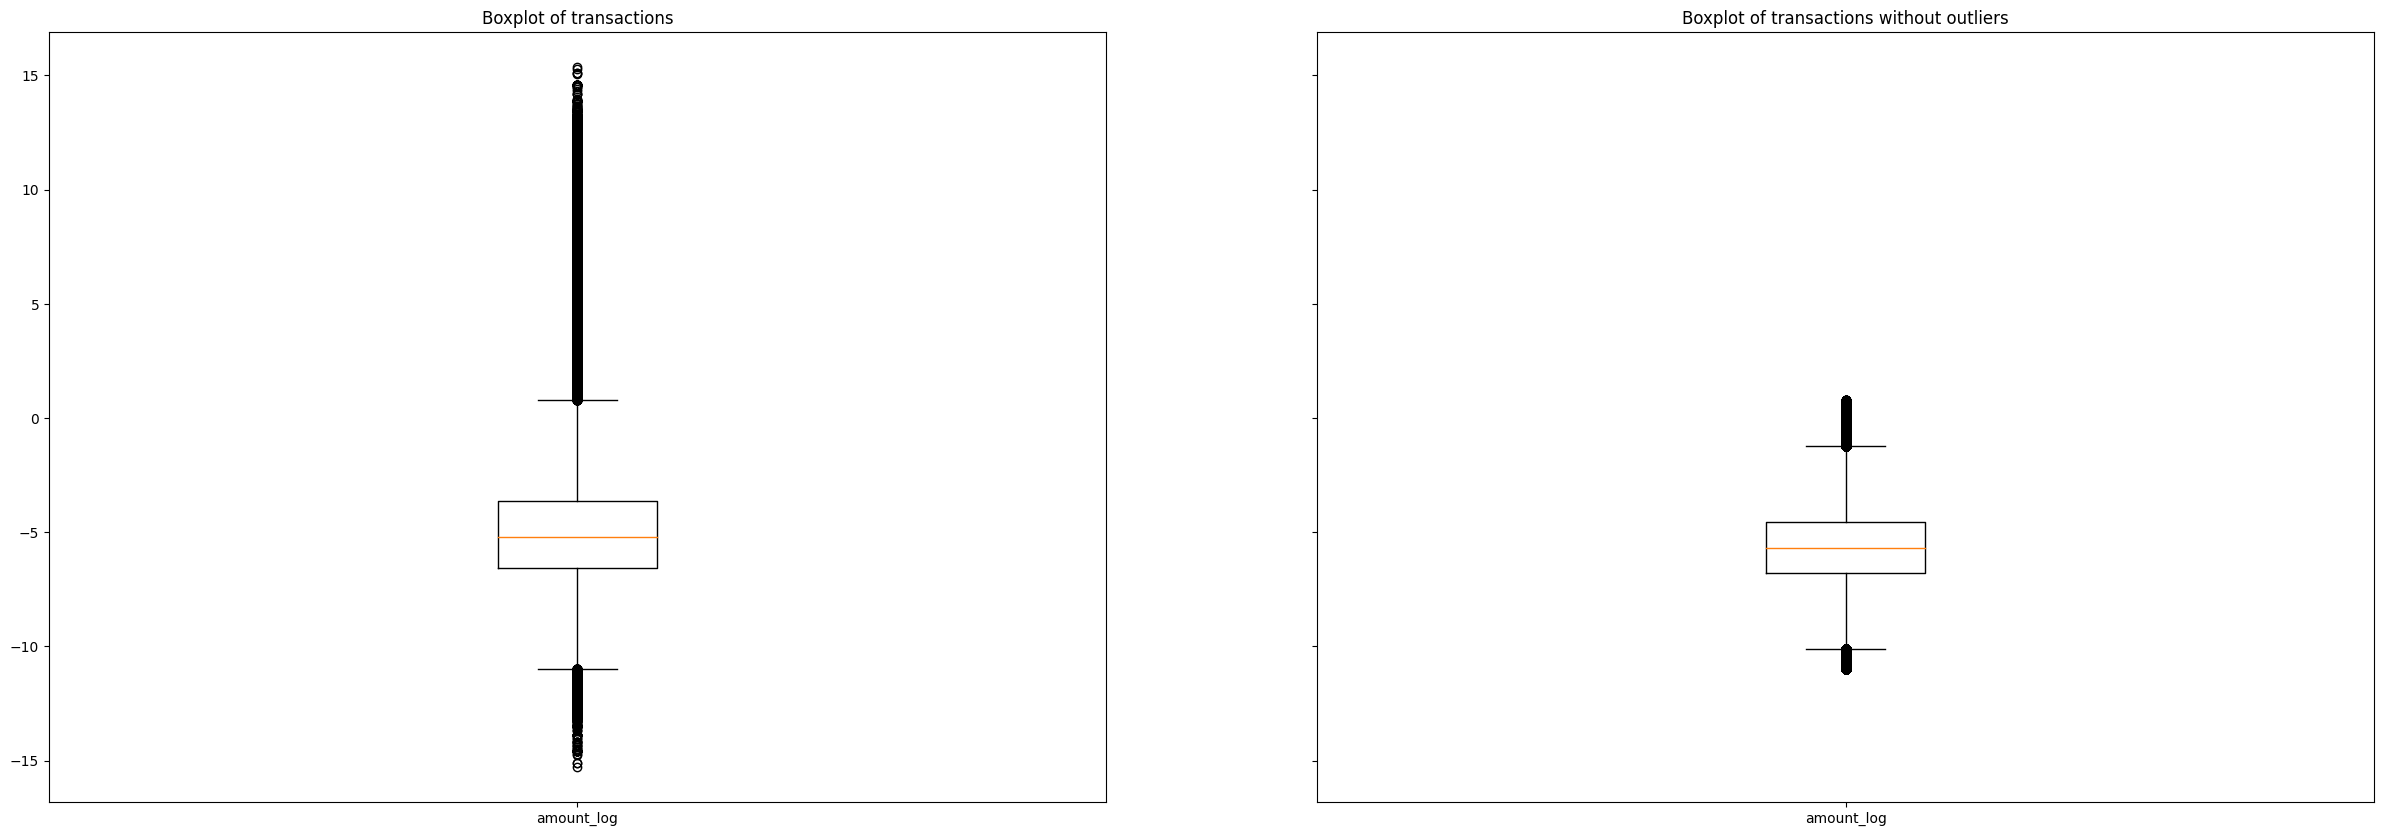

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(30, 10))

axes[0].set_title('Boxplot of transactions')

labels = ['amount_log']
axes[0].boxplot(transactions['amount_log'], labels=labels)
axes[1].set_title('Boxplot of transactions without outliers')
axes[1].boxplot(data_with_no_outliers, labels=labels)

#plt.suptitle('Boxplot of transactions')
plt.show()

<Axes: xlabel='mcc_description'>

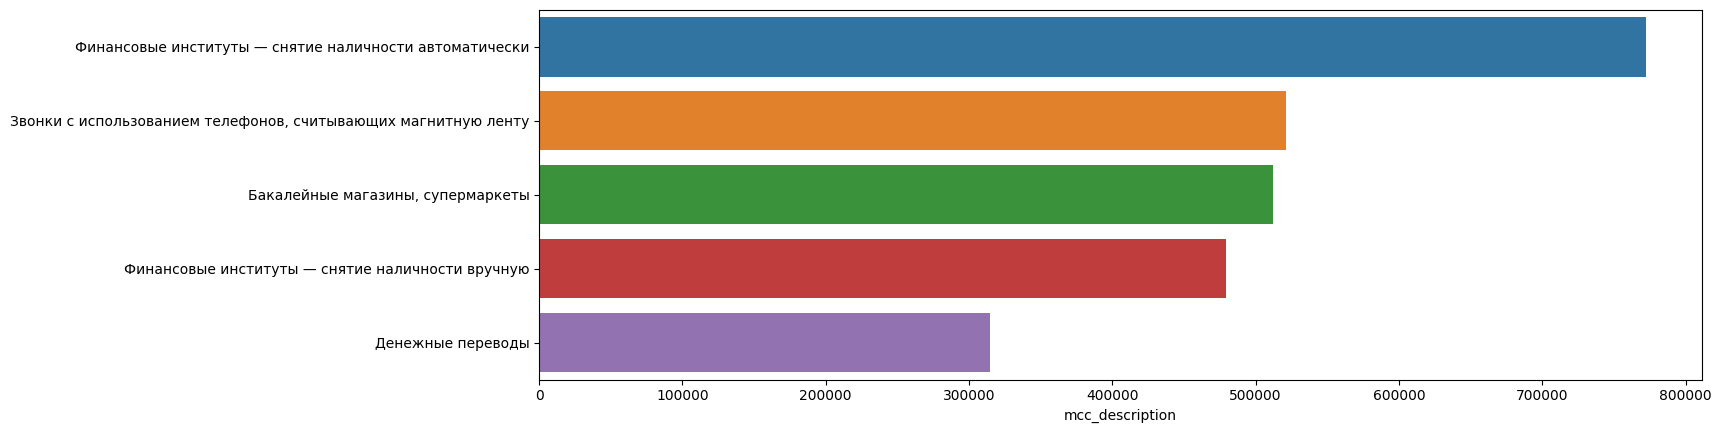

In [13]:
# services most often used by bank customers

fig, axs = plt.subplots(ncols=1)
fig.set_figwidth(15)

data0 = transactions.merge(mcc_codes, on='mcc_code')
data = data0.merge(trans_types, on='trans_type')


# top 5 of transaction codes
sns.barplot(x=data['mcc_description'].value_counts()[:5],y=data['mcc_description'].value_counts()[:5].index)

<Axes: xlabel='trans_description'>

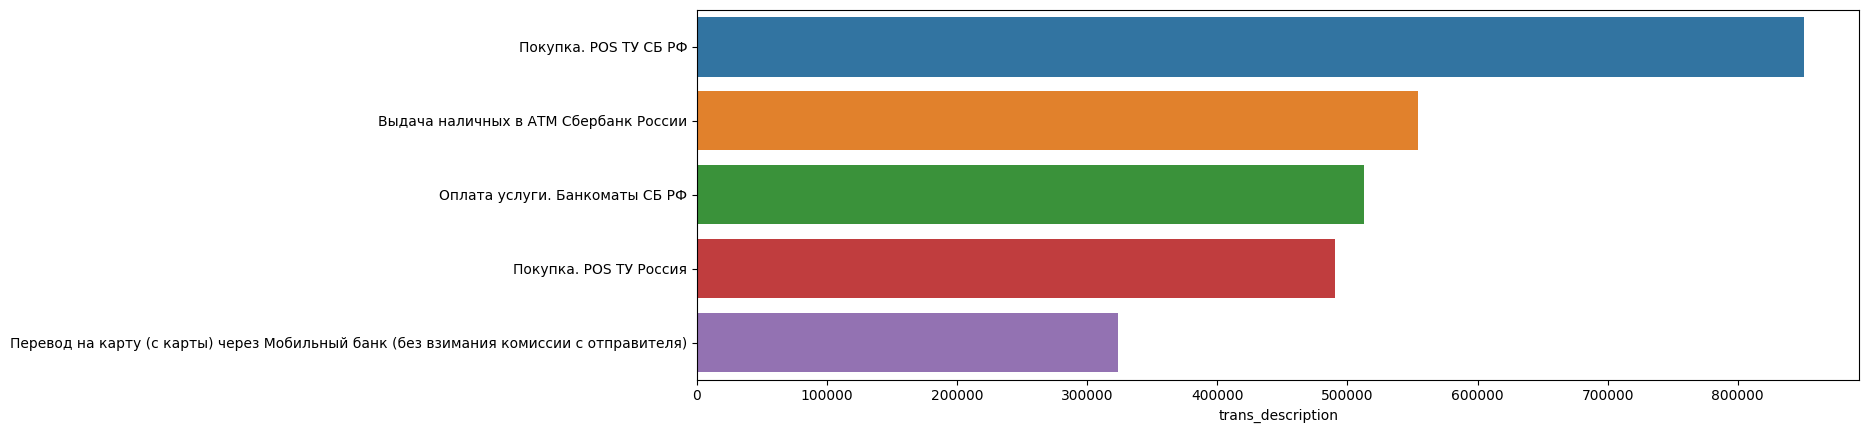

In [14]:
fig, axs = plt.subplots(ncols=1)
fig.set_figwidth(15)

# top 5 of transaction types
sns.barplot(x=data['trans_description'].value_counts()[:5],y=data['trans_description'].value_counts()[:5].index)

In [15]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,amount_log
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,-7.500839
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,8.981620
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,-9.416912
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,3.922369
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,3.834926


In [16]:
transactions.loc[transactions['amount'] > 0, 'income'] = transactions['amount']
transactions.loc[transactions['amount'] <= 0, 'spent'] = transactions['amount']

In [17]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,-7.500839,NaN,-1808.56
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,8.981620,7954.51,NaN
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,-9.416912,NaN,-12293.56
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,3.922369,49.52,NaN
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,3.834926,45.29,NaN


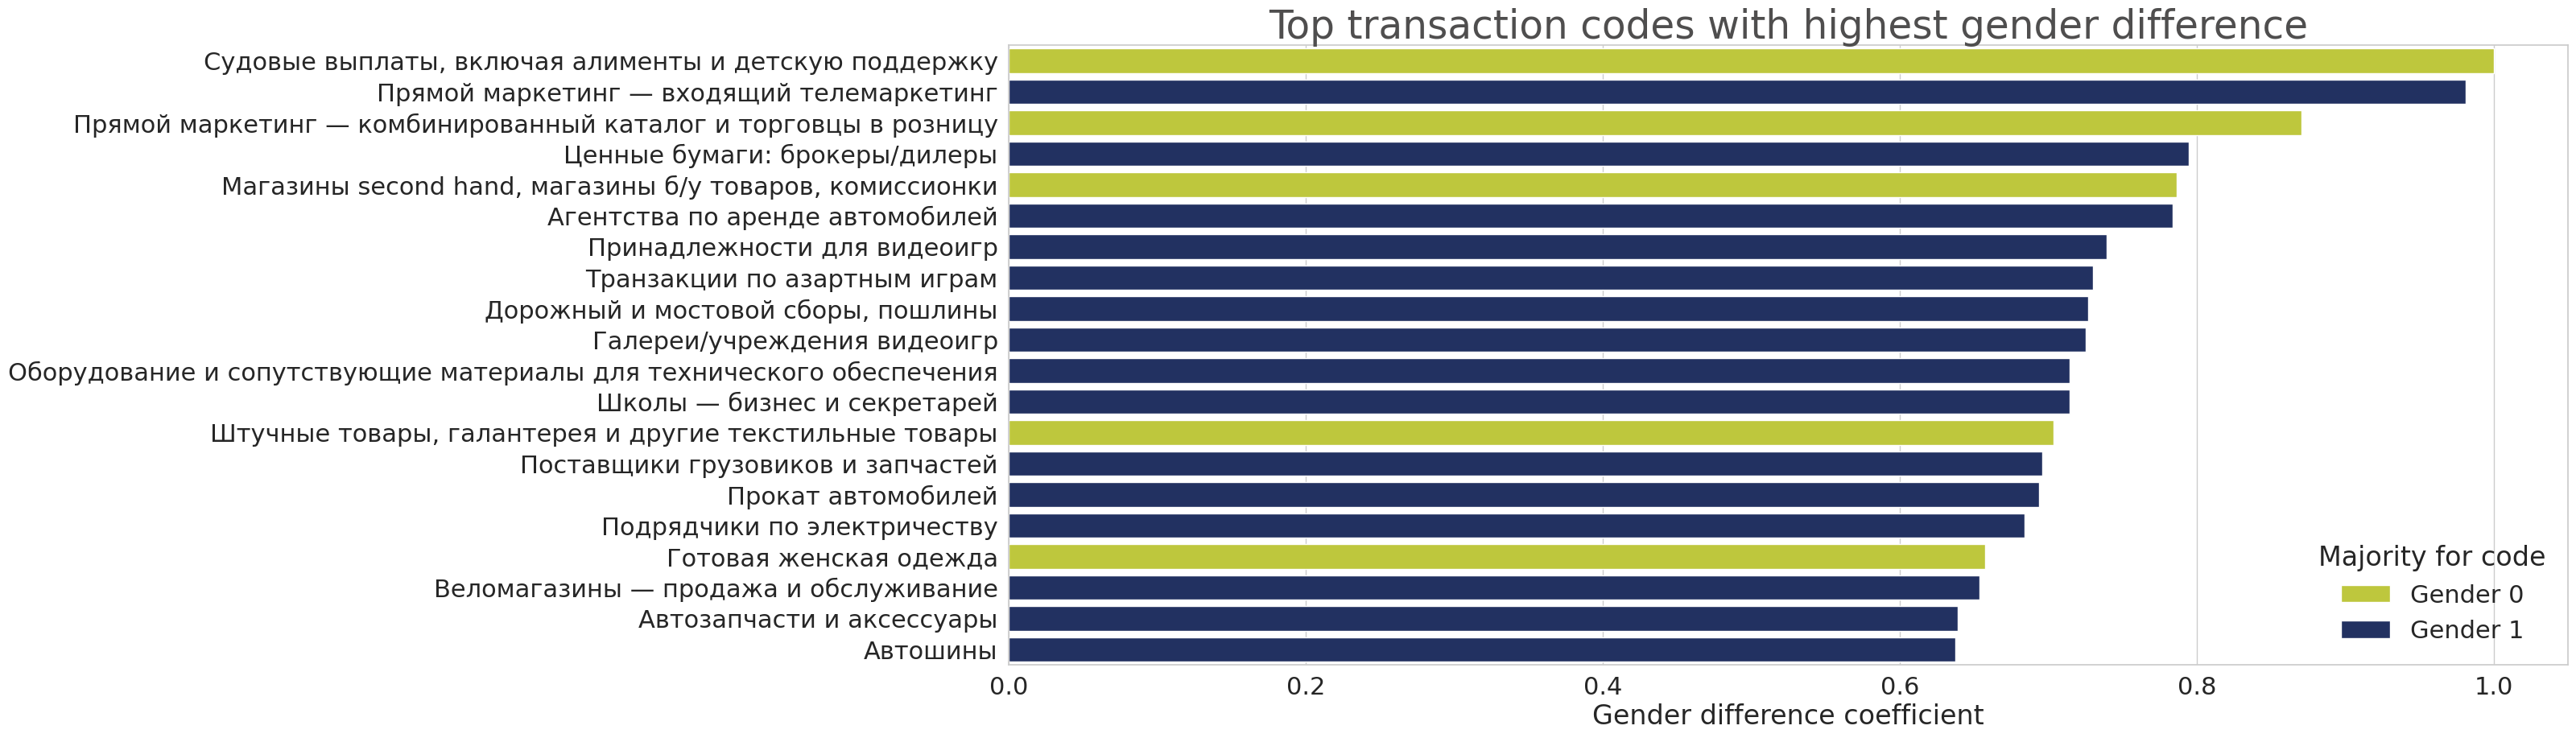

In [18]:
# counting the number of transactions made per gender by code type

train_gender = mcc_codes.copy(deep=True)
train_gender['majority'] = 0


data_train = pd.merge(transactions, train, on='client_id', how="right")

def calc_count_0(row):
    return len((data_train[(data_train['mcc_code'] == row['mcc_code']) & (data_train['gender'] == 0)]))

def calc_count_1(row):
    return len((data_train[(data_train['mcc_code'] == row['mcc_code']) & (data_train['gender'] == 1)]))

train_gender['0'] = train_gender.apply(lambda row: calc_count_0(row), axis=1)
train_gender['1'] = train_gender.apply(lambda row: calc_count_1(row), axis=1)


train_gender['coef'] = abs(train_gender['0'] - train_gender['1'])/(train_gender['0'] + train_gender['1'])

train_gender['majority'] = train_gender['1'] > train_gender['0']


plt.figure(figsize=(25,10))
sns.set(font_scale=2,style='whitegrid')


ax = sns.barplot(x="coef", y="mcc_description", data=train_gender.sort_values(by=['coef'], ascending=False).head(20),
            hue='majority', palette={True:'#182c6bff', False:'#d2de26ff'}, dodge=False)
plt.title('Top transaction codes with highest gender difference', size = 35, color='#4f4e4e')
plt.xlabel('Gender difference coefficient')
plt.ylabel('')

labels = ['Gender 0', 'Gender 1']
h, l = ax.get_legend_handles_labels()

ax.legend(h, labels, title="Majority for code", framealpha=0.0, loc="lower right")

In [20]:
cool_mcc = list(train_gender.sort_values('coef', ascending=False).iloc[:20]['mcc_code'])

In [21]:
transactions['mcc_code'].value_counts().reset_index()[transactions['mcc_code'].value_counts().reset_index()['index'].isin(cool_mcc)]

,index,mcc_code
19,7995,12744
23,5533,11185
39,7994,5233
44,5621,4287
81,4784,841
85,6211,750
99,7993,468
102,5532,338
107,5931,289
113,5013,240


In [22]:
transactions.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver,-7.500839,NaN,-1808.56
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan,8.981620,7954.51,NaN
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk,-9.416912,NaN,-12293.56
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad,3.922369,49.52,NaN
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg,3.834926,45.29,NaN


In [23]:
trans_train = pd.merge(transactions, train, on='client_id')
trans_test = pd.merge(transactions, test, on='client_id')

In [25]:
base_date = pd.to_datetime('2022-01-01')

for df in [trans_train, trans_test]:
    df['trans_time'] = df['trans_time'].astype(str)
    df[['days', 'time']] = df['trans_time'].str.split(' ', expand=True)
    df['days'] = pd.to_timedelta(df['days'].astype(int), unit='D')
    df['time'] = pd.to_timedelta(df['time'])
    df['event_time'] = base_date + df['days'] + df['time']
    #df['hour'] = df['hour'].astype(np.float32)
    df.drop(['trans_time', 'days', 'time'], axis=1, inplace=True)

In [29]:
trans_train.tail(30)

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time
3238702,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-4482.88,600921,Tver,-8.408244,NaN,-4482.88,0,2023-03-09 13:24:04
3238703,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-325.42,600921,Tver,-5.788185,NaN,-325.42,0,2023-01-12 13:44:16
3238704,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.74,295913,Vladimir,8.392251,4411.74,NaN,1,2022-12-29 16:26:10
3238705,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.86,295913,Vladimir,8.392278,4411.86,NaN,1,2022-10-27 10:05:00
3238706,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4339.71,295913,Vladimir,8.375793,4339.71,NaN,1,2023-02-28 17:02:23
3238707,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4410.19,295913,Vladimir,8.391900,4410.19,NaN,1,2023-01-28 14:05:01
3238708,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4483.95,295913,Vladimir,8.408483,4483.95,NaN,1,2022-11-29 12:26:56
3238709,9545145a10b75ff838025dd42a74b73a,6011,2010,-10847.02,NaN,Vladimir,-9.291738,NaN,-10847.02,0,2022-02-13 21:42:22
3238710,9545145a10b75ff838025dd42a74b73a,6010,7070,723.57,888987,Vladimir,6.585578,723.57,NaN,0,2022-08-21 19:43:09
3238711,9545145a10b75ff838025dd42a74b73a,6011,2010,-21693.49,NaN,Vladimir,-9.984814,NaN,-21693.49,0,2022-01-16 15:07:27


In [30]:
trans_train.head()

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,4829,2370,-1808.56,NaN,Tver,-7.500839,NaN,-1808.56,0,2022-02-05 08:24:41
1,d1bbbc9a0e0410d3cf12a3d2f44f3450,4829,2370,-3390.41,NaN,Tver,-8.129001,NaN,-3390.41,0,2022-04-16 12:57:32
2,d1bbbc9a0e0410d3cf12a3d2f44f3450,4814,1030,-144.50,889003,Tver,-4.980176,NaN,-144.50,0,2023-04-01 19:32:01
3,d1bbbc9a0e0410d3cf12a3d2f44f3450,6011,2010,-3542.30,NaN,Tver,-8.172814,NaN,-3542.30,0,2022-03-25 09:22:26
4,d1bbbc9a0e0410d3cf12a3d2f44f3450,6011,2010,-3542.70,NaN,Tver,-8.172927,NaN,-3542.70,0,2022-03-16 13:31:57


In [31]:
#from datetime import datetime
#trans_train['event_time'] = pd.to_datetime(trans_train['event_time'])




#to get hour and minute
trans_train['hour'] = trans_train['event_time'].dt.strftime('%H')


In [32]:
trans_train.tail(30)

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time,hour
3238702,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-4482.88,600921,Tver,-8.408244,NaN,-4482.88,0,2023-03-09 13:24:04,13
3238703,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-325.42,600921,Tver,-5.788185,NaN,-325.42,0,2023-01-12 13:44:16,13
3238704,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.74,295913,Vladimir,8.392251,4411.74,NaN,1,2022-12-29 16:26:10,16
3238705,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.86,295913,Vladimir,8.392278,4411.86,NaN,1,2022-10-27 10:05:00,10
3238706,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4339.71,295913,Vladimir,8.375793,4339.71,NaN,1,2023-02-28 17:02:23,17
3238707,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4410.19,295913,Vladimir,8.391900,4410.19,NaN,1,2023-01-28 14:05:01,14
3238708,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4483.95,295913,Vladimir,8.408483,4483.95,NaN,1,2022-11-29 12:26:56,12
3238709,9545145a10b75ff838025dd42a74b73a,6011,2010,-10847.02,NaN,Vladimir,-9.291738,NaN,-10847.02,0,2022-02-13 21:42:22,21
3238710,9545145a10b75ff838025dd42a74b73a,6010,7070,723.57,888987,Vladimir,6.585578,723.57,NaN,0,2022-08-21 19:43:09,19
3238711,9545145a10b75ff838025dd42a74b73a,6011,2010,-21693.49,NaN,Vladimir,-9.984814,NaN,-21693.49,0,2022-01-16 15:07:27,15


In [33]:
trans_train.shape

(3238732, 12)

In [34]:
trans_train['hour'] = trans_train['hour'].astype(int)


In [36]:
trans_train['hour'].nunique()

24

In [37]:
trans_train.shape

(3238732, 12)

In [40]:
trans_train.tail(30)

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time,hour
3238702,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-4482.88,600921,Tver,-8.408244,NaN,-4482.88,0,2023-03-09 13:24:04,13
3238703,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-325.42,600921,Tver,-5.788185,NaN,-325.42,0,2023-01-12 13:44:16,13
3238704,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.74,295913,Vladimir,8.392251,4411.74,NaN,1,2022-12-29 16:26:10,16
3238705,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.86,295913,Vladimir,8.392278,4411.86,NaN,1,2022-10-27 10:05:00,10
3238706,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4339.71,295913,Vladimir,8.375793,4339.71,NaN,1,2023-02-28 17:02:23,17
3238707,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4410.19,295913,Vladimir,8.391900,4410.19,NaN,1,2023-01-28 14:05:01,14
3238708,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4483.95,295913,Vladimir,8.408483,4483.95,NaN,1,2022-11-29 12:26:56,12
3238709,9545145a10b75ff838025dd42a74b73a,6011,2010,-10847.02,NaN,Vladimir,-9.291738,NaN,-10847.02,0,2022-02-13 21:42:22,21
3238710,9545145a10b75ff838025dd42a74b73a,6010,7070,723.57,888987,Vladimir,6.585578,723.57,NaN,0,2022-08-21 19:43:09,19
3238711,9545145a10b75ff838025dd42a74b73a,6011,2010,-21693.49,NaN,Vladimir,-9.984814,NaN,-21693.49,0,2022-01-16 15:07:27,15


In [41]:
trans_train['Night'] = ((trans_train['hour'] < 5)) | ((trans_train['hour'] > 23))
trans_train['Morning'] = ((trans_train['hour'] < 10)) & ((trans_train['hour'] > 5))
trans_train['Day'] = ((trans_train['hour'] < 17)) & ((trans_train['hour'] > 10))


trans_train['Evening'] = ((trans_train['hour'] < 23)) & ((trans_train['hour'] > 17))



#trans_train['hour_cat'] = pd.cut(trans_train['hour'], bins=b, labels=l, include_lowest=True)

In [43]:
trans_train.tail(30)

,client_id,mcc_code,trans_type,amount,term_id,trans_city,amount_log,income,spent,gender,event_time,hour,Night,Morning,Day,Evening
3238702,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-4482.88,600921,Tver,-8.408244,NaN,-4482.88,0,2023-03-09 13:24:04,13,False,False,True,False
3238703,cd44c7a440fc14f148b51eb8e896d23a,6011,2010,-325.42,600921,Tver,-5.788185,NaN,-325.42,0,2023-01-12 13:44:16,13,False,False,True,False
3238704,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.74,295913,Vladimir,8.392251,4411.74,NaN,1,2022-12-29 16:26:10,16,False,False,True,False
3238705,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4411.86,295913,Vladimir,8.392278,4411.86,NaN,1,2022-10-27 10:05:00,10,False,False,False,False
3238706,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4339.71,295913,Vladimir,8.375793,4339.71,NaN,1,2023-02-28 17:02:23,17,False,False,False,False
3238707,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4410.19,295913,Vladimir,8.391900,4410.19,NaN,1,2023-01-28 14:05:01,14,False,False,True,False
3238708,0506edfbc2d6d505397d456a6c7dbf21,6011,7010,4483.95,295913,Vladimir,8.408483,4483.95,NaN,1,2022-11-29 12:26:56,12,False,False,True,False
3238709,9545145a10b75ff838025dd42a74b73a,6011,2010,-10847.02,NaN,Vladimir,-9.291738,NaN,-10847.02,0,2022-02-13 21:42:22,21,False,False,False,True
3238710,9545145a10b75ff838025dd42a74b73a,6010,7070,723.57,888987,Vladimir,6.585578,723.57,NaN,0,2022-08-21 19:43:09,19,False,False,False,True
3238711,9545145a10b75ff838025dd42a74b73a,6011,2010,-21693.49,NaN,Vladimir,-9.984814,NaN,-21693.49,0,2022-01-16 15:07:27,15,False,False,True,False


In [44]:
(trans_train['Morning'] == True).value_counts()

False    2778012
True      460720
Name: Morning, dtype: int64

In [45]:
(trans_train['Day'] == True).value_counts()

False    2014055
True     1224677
Name: Day, dtype: int64

In [46]:
(trans_train['Evening'] == True).value_counts()

False    2664071
True      574661
Name: Evening, dtype: int64

In [47]:
(trans_train['Night'] == True).value_counts()

False    2915448
True      323284
Name: Night, dtype: int64

In [48]:
labels = ['Morning', 'Daytime', 'Evening', 'Night']
values = [460720, 1224677, 574661, 323284]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

In [49]:


rs = np.random.RandomState(42)
corr = trans_train.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-49-c2f58c7261f3>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,mcc_code,trans_type,amount,amount_log,income,spent,gender,hour,Night,Morning,Day,Evening
mcc_code,1.000000,0.323946,0.049235,0.256663,0.005701,-0.009462,0.031061,-0.024738,0.035260,-0.005642,0.000840,-0.058961
trans_type,0.323946,1.000000,0.140078,0.885299,0.007720,-0.118107,0.006788,-0.021758,-0.069368,0.057220,0.046201,0.001418
amount,0.049235,0.140078,1.000000,0.267102,1.000000,1.000000,-0.007864,0.002595,-0.000124,-0.001559,-0.000406,0.005588
amount_log,0.256663,0.885299,0.267102,1.000000,0.371096,0.340503,-0.009924,-0.016240,-0.034212,0.036648,0.019423,0.010827
income,0.005701,0.007720,1.000000,0.371096,1.000000,nan,0.031646,0.015060,-0.020508,-0.006472,0.009066,0.002628
spent,-0.009462,-0.118107,1.000000,0.340503,nan,1.000000,-0.028529,0.003695,0.019279,-0.011330,-0.012988,0.007239
gender,0.031061,0.006788,-0.007864,-0.009924,0.031646,-0.028529,1.000000,-0.002900,0.045726,-0.015114,-0.036007,0.009723
hour,-0.024738,-0.021758,0.002595,-0.016240,0.015060,0.003695,-0.002900,1.000000,-0.662971,-0.346234,0.060339,0.492569
Night,0.035260,-0.069368,-0.000124,-0.034212,-0.020508,0.019279,0.045726,-0.662971,1.000000,-0.135610,-0.259666,-0.154658
Morning,-0.005642,0.057220,-0.001559,0.036648,-0.006472,-0.011330,-0.015114,-0.346234,-0.135610,1.000000,-0.317561,-0.189140


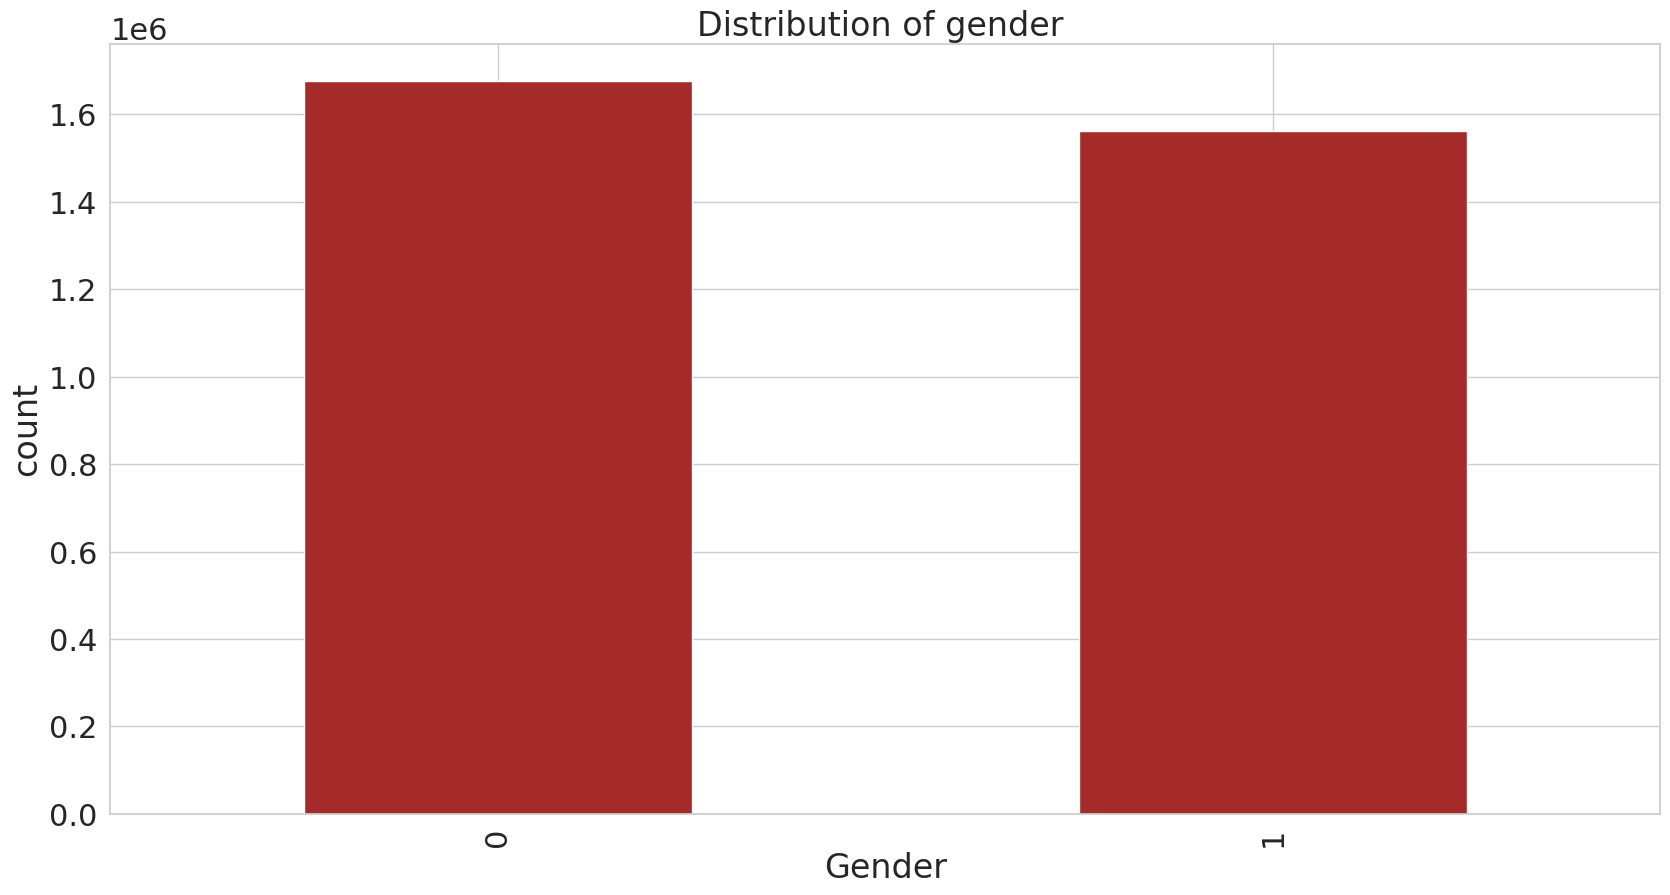

In [51]:

trans_train['gender'].value_counts(normalize = True)
trans_train['gender'].value_counts(dropna = False).plot.bar(color = 'brown', figsize = (20, 10))

plt.title('Distribution of gender ')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()